# Plot results from hyper-parameter tuning with scikit

This notebook demonstrates how to visualize the results from machine learning on the pulse best-fit parameters done in the notebook `demo_ml_scikit_fit_pars.ipynb`.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import logging
from pathlib import PosixPath
from fastespy.utils import init_logging
from IPython.display import Image, display

Initialize nice colorful logging

In [2]:
init_logging("INFO", color=True)

Set the parameters as in `demo_ml_scikit_fit_pars.ipynb`

In [3]:
# classifier with naming scheme as before
classifier_name = 'rf'

# did you log transform the data?
log_data = True

# Did you use PCA to transform data?
use_pca = True

# output directory for ML results
indir = f"/Users/manuelmeyer/Documents/TESData/ml_extrinsic_may2021"
print(indir)

/Users/manuelmeyer/Documents/TESData/ml_extrinsic_may2021


Get the result files from ML

In [4]:
in_dir = PosixPath(indir)

Get a list of files and read in the results. There should be one file for each $K$-fold iteration.

In [5]:
files = list(in_dir.glob(f"*/r{classifier_name:s}*.npy"))

logging.info("Using files:")
results = []
for f in files:
    logging.info(f)
    r = np.load(f, allow_pickle=True).flat[0]
    results.append(r)

1007775299.py:   3 --- INFO: Using files:
1007775299.py:   6 --- INFO: /Users/manuelmeyer/Documents/TESData/ml_extrinsic_may2021/00001/rrf_cleaned_reduced.npy
1007775299.py:   6 --- INFO: /Users/manuelmeyer/Documents/TESData/ml_extrinsic_may2021/00004/rrf_cleaned_reduced.npy
1007775299.py:   6 --- INFO: /Users/manuelmeyer/Documents/TESData/ml_extrinsic_may2021/00003/rrf_cleaned_reduced.npy
1007775299.py:   6 --- INFO: /Users/manuelmeyer/Documents/TESData/ml_extrinsic_may2021/00002/rrf_cleaned_reduced.npy
1007775299.py:   6 --- INFO: /Users/manuelmeyer/Documents/TESData/ml_extrinsic_may2021/00005/rrf_cleaned_reduced.npy


In [6]:
print(results[0].keys())

dict_keys(['results', 'y_pred_test', 'y_pred_train', 'prob_test', 'prob_train', 'X_train', 'X_test', 'y_train', 'y_test', 'idx_test', 'scoring', 'grid', 't_obs', 'dark_current'])


Get the scorers that have been used for the optimization of the classifier:

In [7]:
scores = list(results[0]['results']['learning_curve'].keys())
print(scores)

['AUC', 'Accuracy', 'Significance']


We select one score, for which we will look at the results.

In [8]:
score = scores[-1]
print(score)

Significance


In [9]:
%load_ext autoreload

In [10]:
%autoreload 2

In [11]:
%matplotlib inline

## Plot the parameter profiles

For each $K$-fold iteration, we plot the parameter profiles below. From this one can see how well the classifier performs roughly and how strongly the hyper-parameters vary with each random selection of training and validation data that result in the best classification. 

In [12]:
from fastespy.mlscikit.hyperpartune import MLHyperParTuning

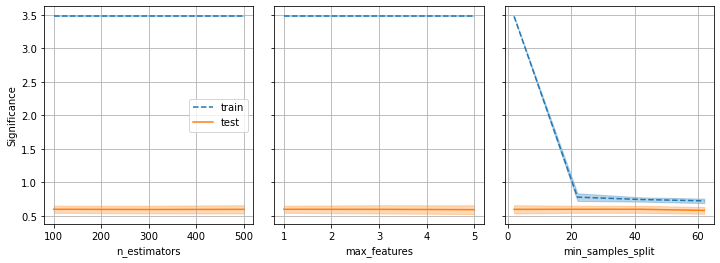

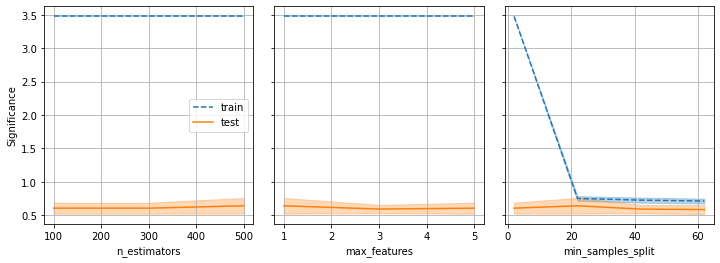

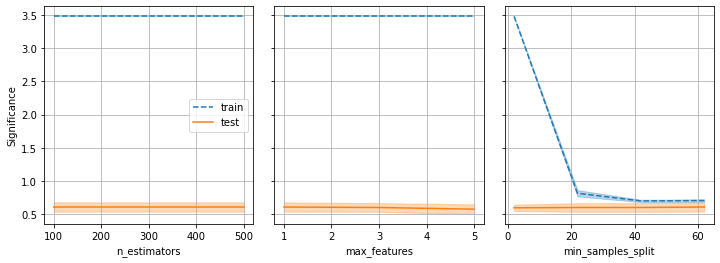

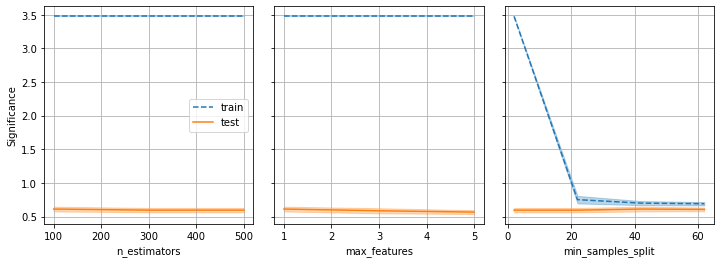

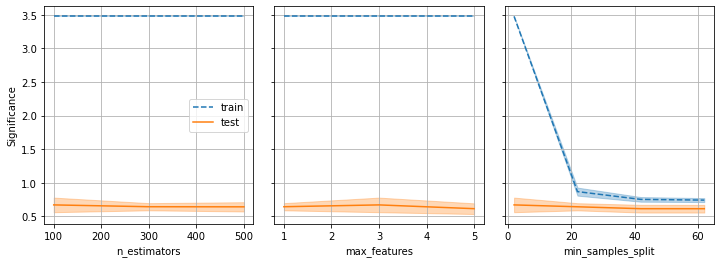

In [13]:
for i, r in enumerate(results):
    MLHyperParTuning.plot_parameter_profiles(r['results'],["Significance"],
                                             classifier_name,
                                             path=None
                                             #path=in_dir / f"./{i+1:05n}"
                                            )

## Confusion matrix, learning curves, misidentified events

The confusion matrix, learning curves, misidentified events are already plotted during the runtime of the hyperparameter optimization. Here we can look at these plots for each $K$-fold iteration. 

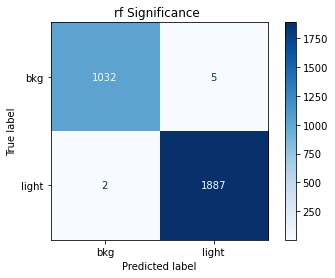

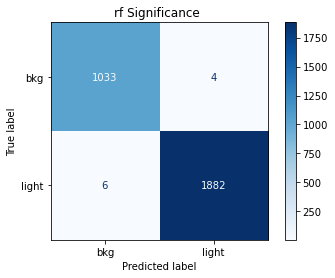

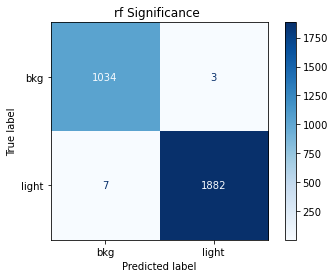

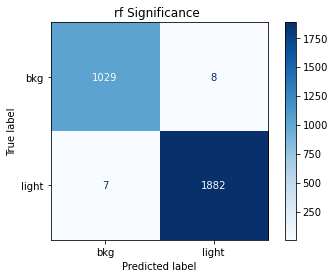

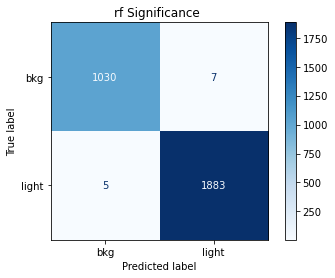

In [14]:
for i, r in enumerate(results):
    MLHyperParTuning.plot_confusion_matrix(r['results'],["Significance"],
                                           classifier_name,
                                           path=None
                                           #path=in_dir / f"./{i+1:05n}"
                                           )

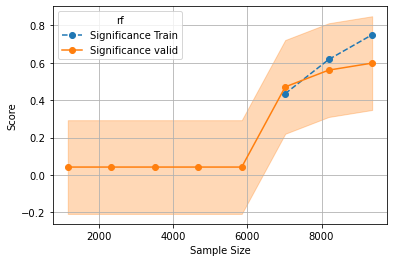

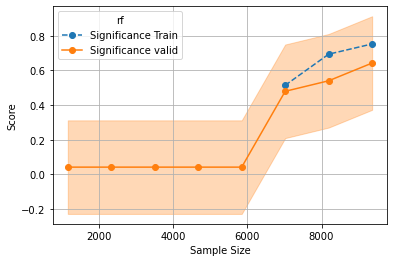

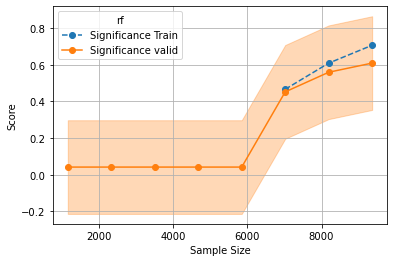

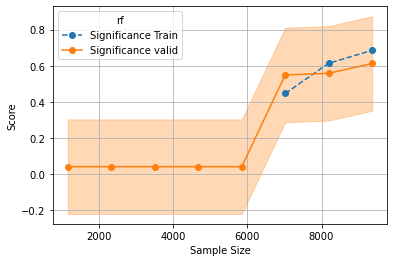

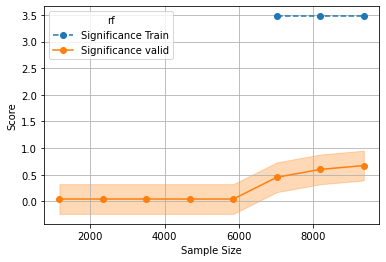

In [15]:
for i, r in enumerate(results):
    MLHyperParTuning.plot_learning_curve(r['results'],
                                         select_score="Significance",
                                         classifier=classifier_name,
                                         path=None
                                         #path=in_dir / f"./{i+1:05n}"
                                         )

### misidentified events

These are generated during run time of the hyper parameter optimization.

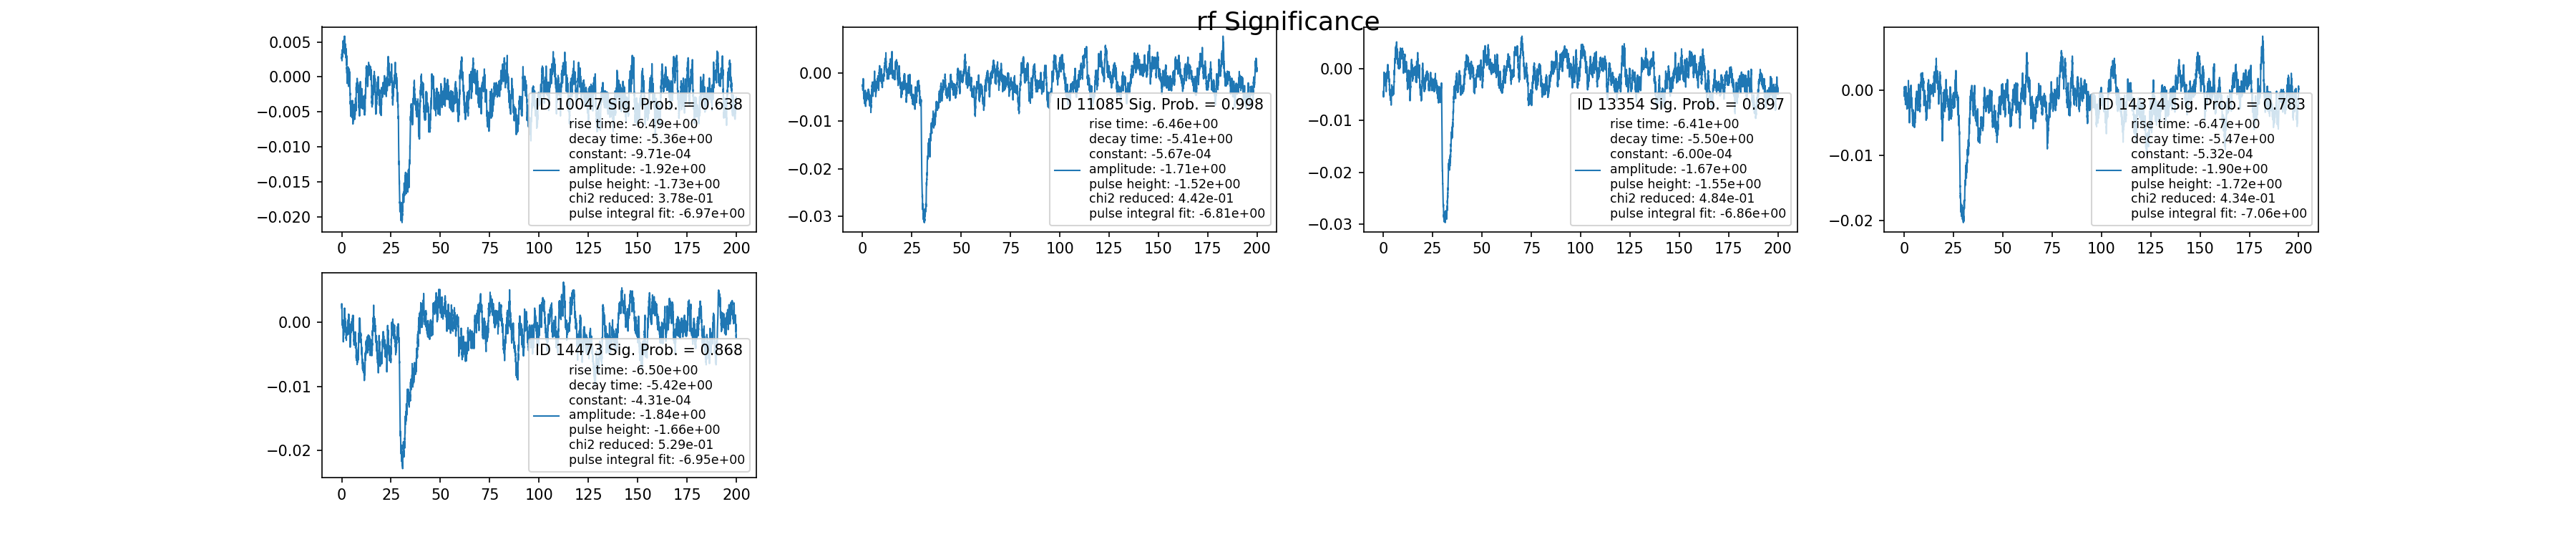

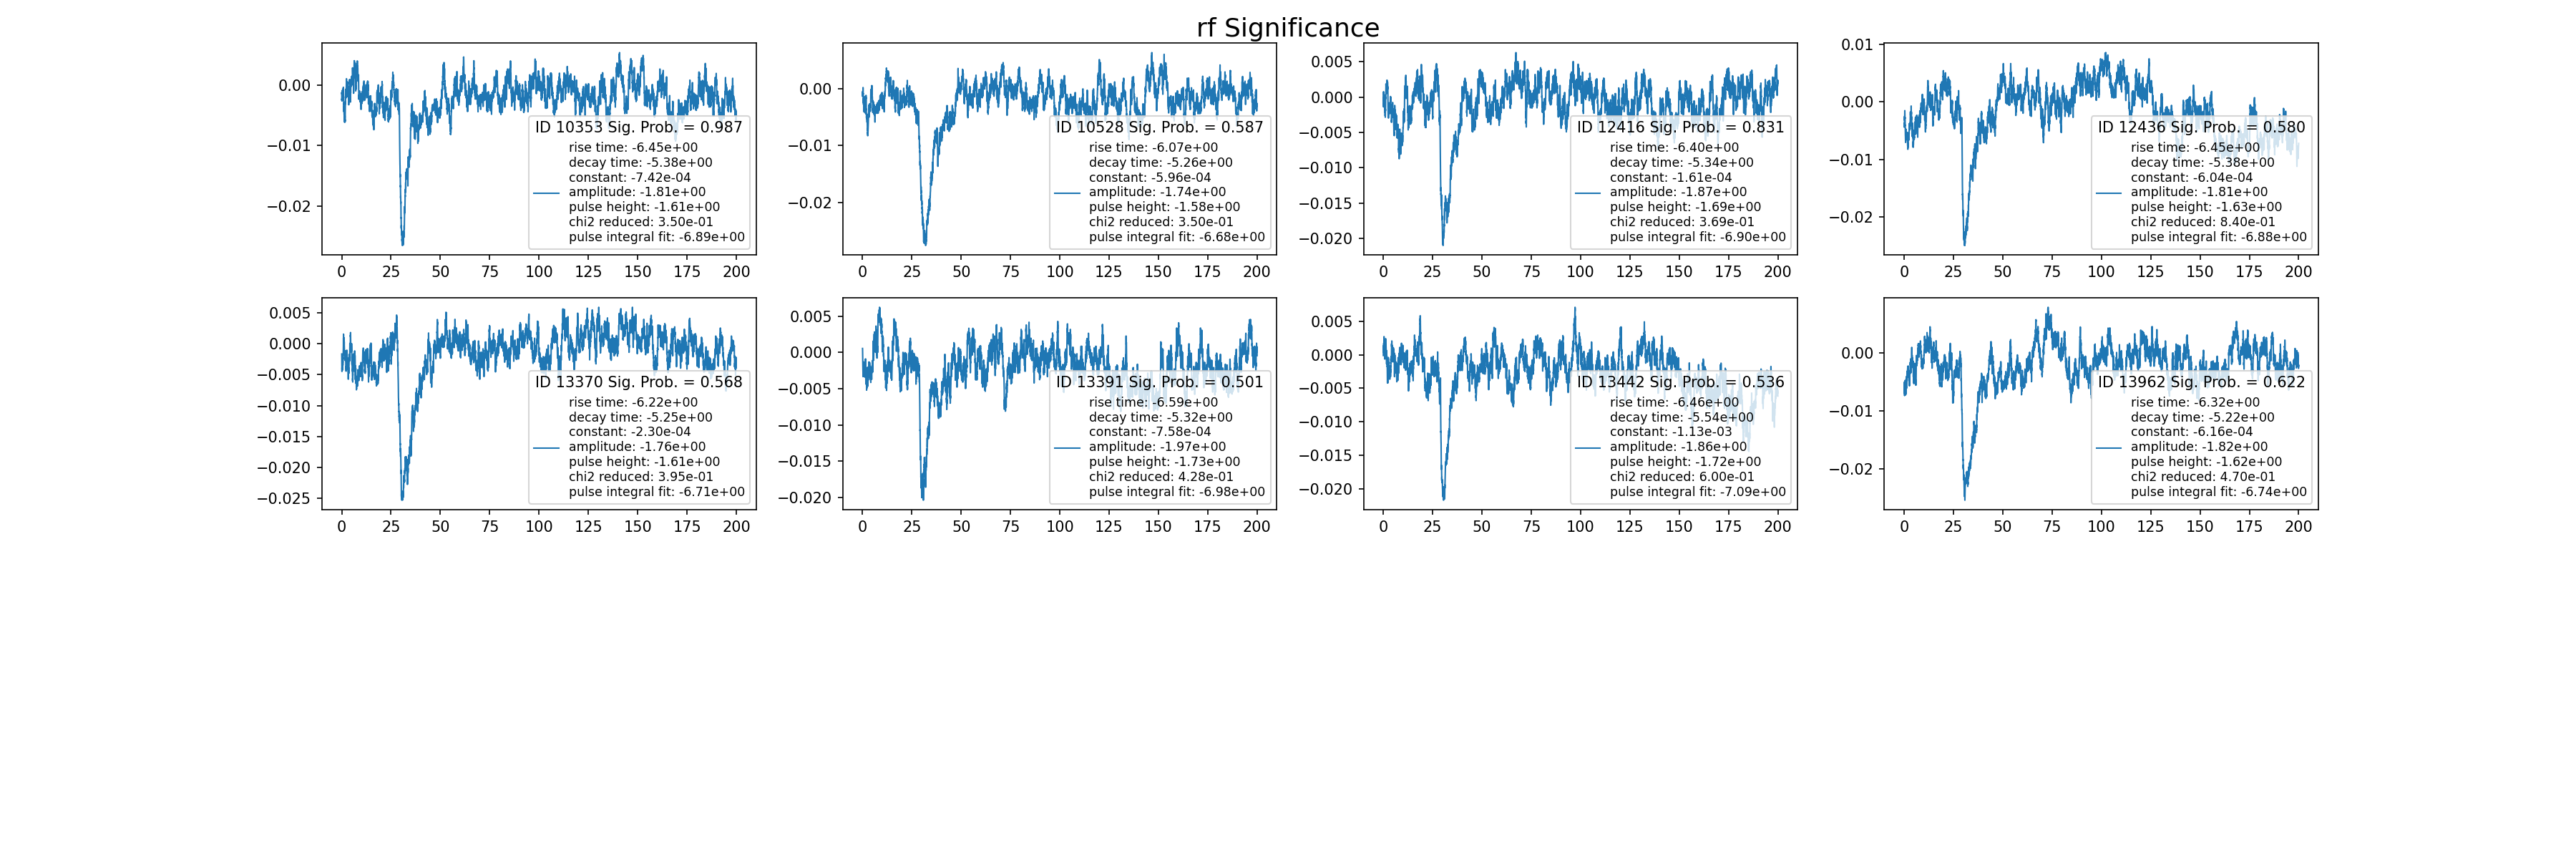

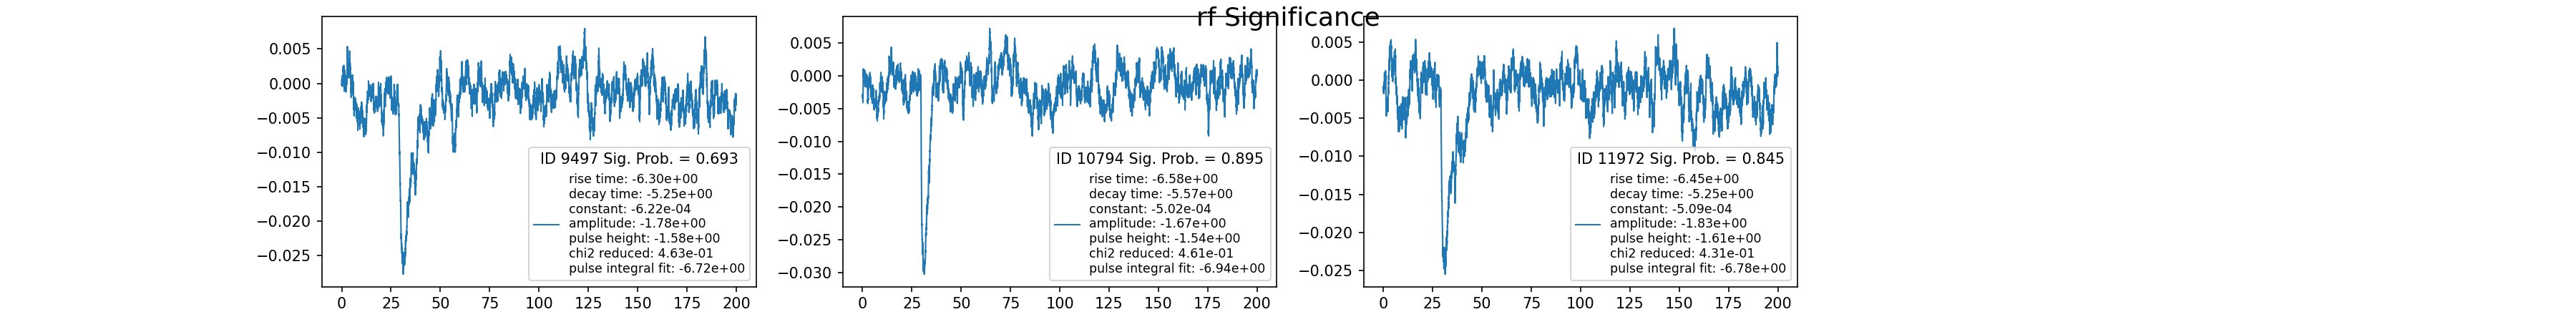

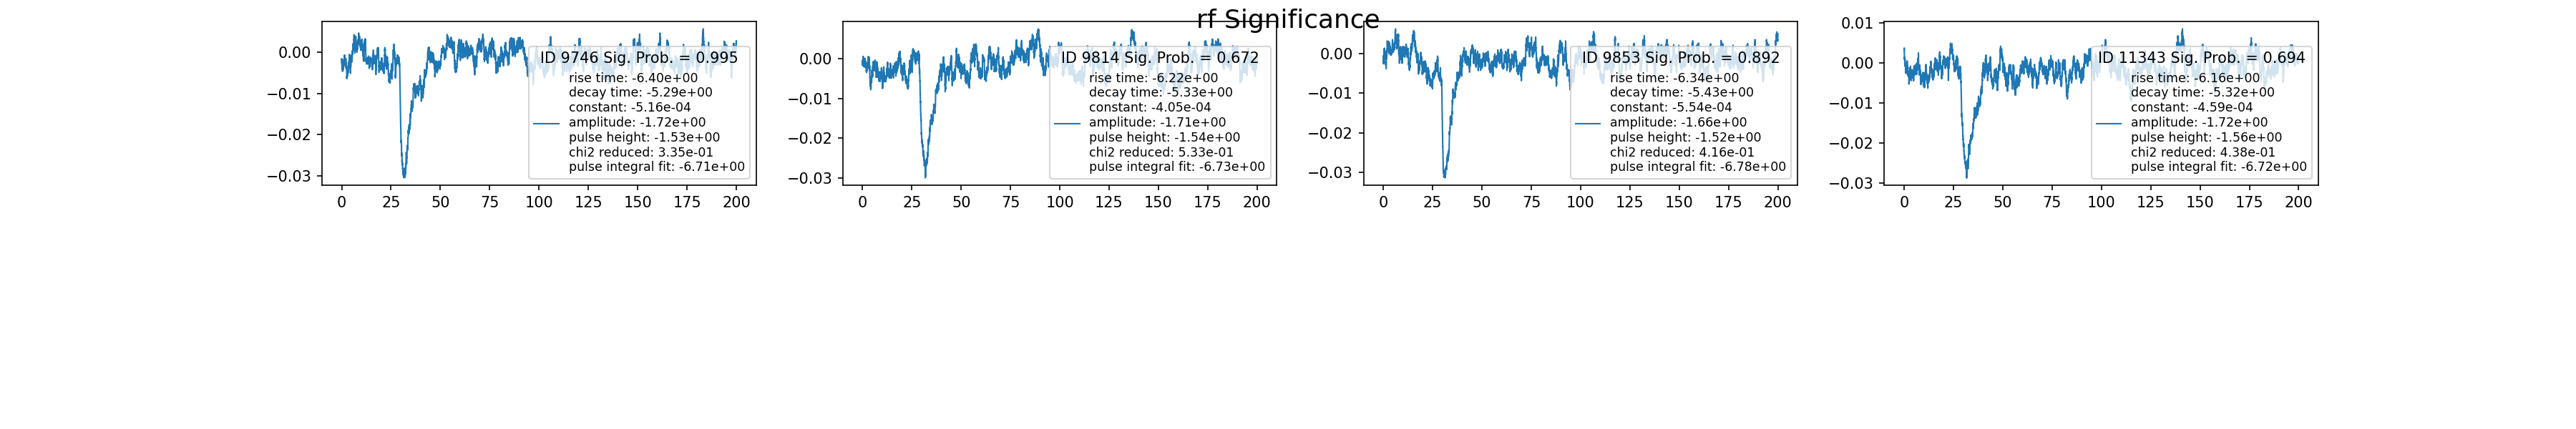

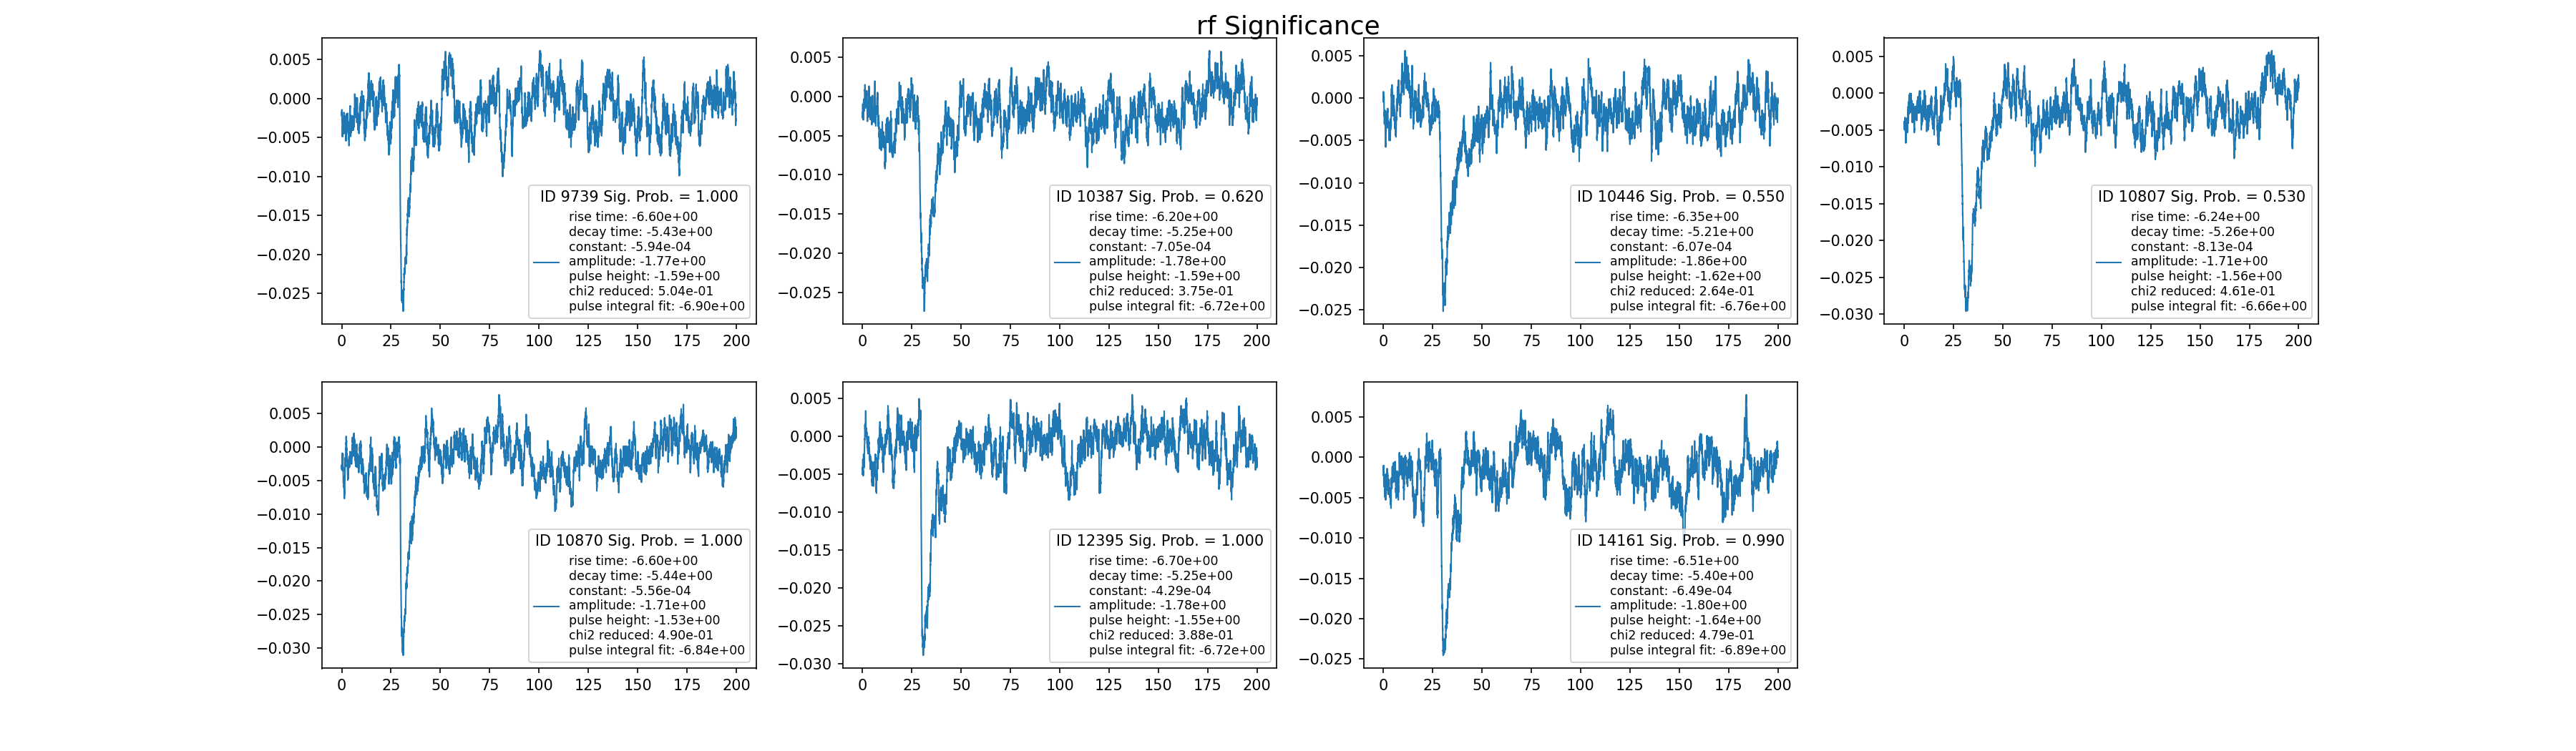

In [16]:
for i in range(len(results)):
    image = in_dir / f"{i+1:05n}" / f"misid_events_fp_{score:s}_{classifier_name:s}.png"
    display(Image(filename=image, width=1024))

# Plots for the overall performance of the classifier

From the $K$ rounds of $K$-fold cross validation, we can now plot the overall performance of the classifier in terms 
of the background rate, signal efficiency, and achieved significance. The performance can also be plotted as a function of the chosen threshold to classify a signal as either signal or background (default is that for a probability $p > 0.5$ for an event to be a signal, it is classified as such). 

In [17]:
from fastespy.mlscikit.hyperpartune import significance

First, let's check the performance against different scorers.

Text(0.5, 0, 'Scorer')

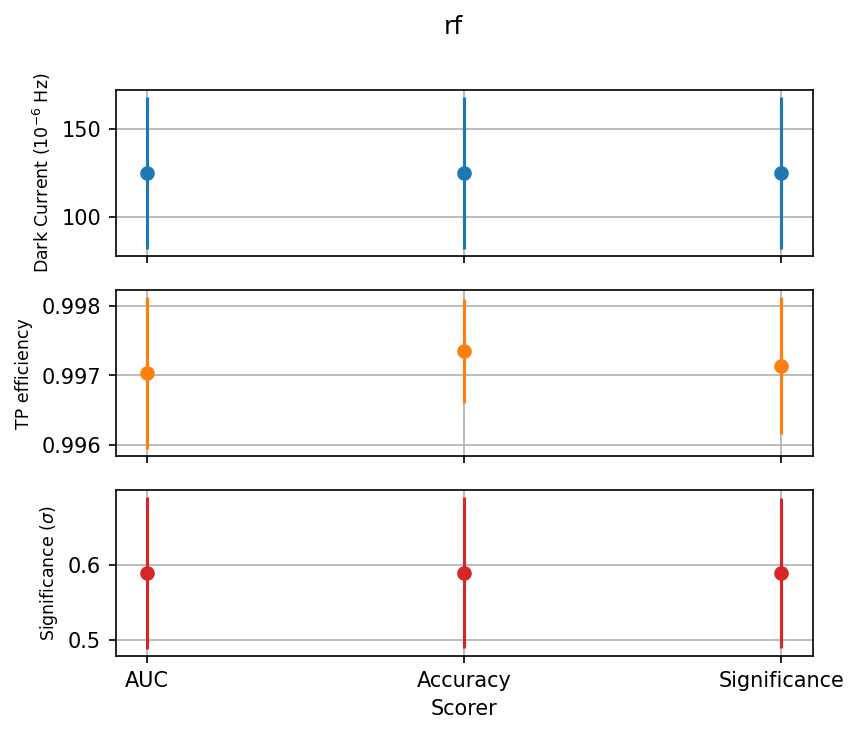

In [18]:
fig = plt.figure(dpi=150, figsize=(6,5))
ax = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

for i, scorer in enumerate(scores):

    dc = []
    sig = []
    tpr = []
    
    for j, r in enumerate(results):
        
        dc.append(r['dark_current'][scorer][1] * 1e6)
        tpr.append(r['results']['tp_efficiency_test'][scorer])
        sig.append(significance(n_b=dc[-1] / 1e6,
                   obs_time=r['t_obs'],
                   e_a=tpr[-1]
                   ))
    ax.errorbar(i + 1, np.mean(dc), yerr=np.sqrt(np.var(dc)), marker='o', color='C0')
    ax2.errorbar(i + 1, np.mean(tpr), yerr=np.sqrt(np.var(tpr)), marker='o', color='C1')
    ax3.errorbar(i + 1, np.mean(sig), yerr=np.sqrt(np.var(sig)), marker='o', color='C3')
    
    
ax.grid()
ax2.grid()
ax3.grid()

plt.suptitle(classifier_name)

ax.tick_params(labelbottom=False)
ax2.tick_params(labelbottom=False)

ax.set_ylabel("Dark Current (10$^{-6}$ Hz)", fontsize='small')
ax2.set_ylabel(r"TP efficiency", fontsize='small')
ax3.set_ylabel(r"Significance ($\sigma$)", fontsize='small')


ax.set_xticks(np.arange(1,len(r['scoring'])+1))
ax2.set_xticks(np.arange(1,len(r['scoring'])+1))
plt.xticks(np.arange(1,len(r['scoring'])+1), r['scoring'])
plt.xlabel("Scorer")

Lastly, we investigate, for one scorer, the performance as a function of the threshold.

In [19]:
from fastespy.plotting import plot_performance_vs_threshold

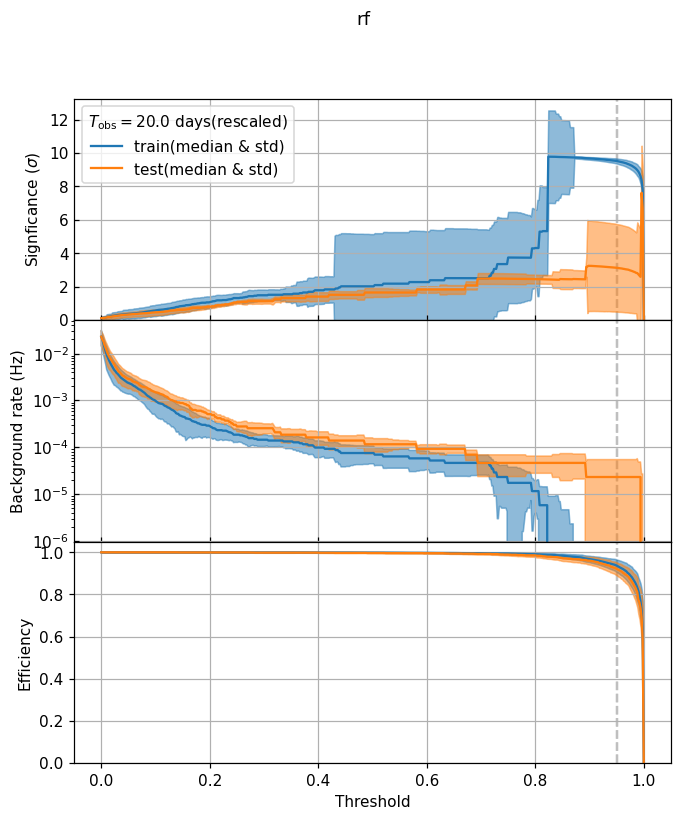

In [95]:
thr = results[0]['results']['thresholds']

for i, t in enumerate(['train', 'test']):
    
    sig, bkg, eff = np.zeros((len(results), thr.size)), np.zeros((len(results), thr.size)), np.zeros((len(results), thr.size))
    
    for j, r in enumerate(results):
        
        sig[j], bkg[j], eff[j] = r['results']['thr_sig_bkg_eff_{0:s}'.format(t)][score]
        
    if not i:
        fig, ax_sig, ax_bkg, ax_eff = plot_performance_vs_threshold(thr,
                                                                    #sig.mean(axis=0), 
                                                                    #bkg.mean(axis=0),
                                                                    #eff.mean(axis=0),
                                                                    np.median(sig, axis=0), 
                                                                    np.median(bkg, axis=0),
                                                                    np.median(eff, axis=0),
                                                                    d_sig=np.sqrt(sig.var(axis=0)),
                                                                    d_bkg=np.sqrt(bkg.var(axis=0)),
                                                                    d_eff=np.sqrt(eff.var(axis=0)),
                                                                    color=f"C{i}",
                                                                    label=t + "(median & std)", 
                                                                    rescale_t_obs_days=20.,
                                                                    t_tot_hours=results[0]['t_obs'] / 3600.
                                                                   )
    else:
        _ = plot_performance_vs_threshold(thr,
                                          #sig.mean(axis=0), 
                                          #bkg.mean(axis=0),
                                          #eff.mean(axis=0),
                                          np.median(sig, axis=0), 
                                          np.median(bkg, axis=0),
                                          np.median(eff, axis=0),
                                          d_sig=np.sqrt(sig.var(axis=0)),
                                          d_bkg=np.sqrt(bkg.var(axis=0)),
                                          d_eff=np.sqrt(eff.var(axis=0)),
                                          color=f"C{i}",
                                          fig=fig, 
                                          ax_eff=ax_eff, 
                                          ax_sig=ax_sig,
                                          ax_bkg=ax_bkg,
                                          label=t + "(median & std)",
                                          classifier_name=classifier_name,
                                          rescale_t_obs_days=20.,
                                          t_tot_hours=results[0]['t_obs'] / 3600.
                                          )

In [96]:
# threshold of 95%
idx95 = np.argmin(np.abs(thr - 0.95))

In [97]:
# print all sig, bkg, eff
print(sig[:,idx95] * np.sqrt(20. * 24. * 3600./ results[0]['t_obs'])) 
print(bkg[:,idx95])
print(eff[:,idx95])

[3.15230877 3.13596586 9.21599365 3.09873352 1.79392813]
[2.31561626e-05 2.31561626e-05 0.00000000e+00 2.31561626e-05
 9.26246505e-05]
[0.92694547 0.92161017 0.87771308 0.90947591 0.97139831]


In [98]:
# print median
print(np.median(sig, axis=0)[idx95] * np.sqrt(20. * 24. * 3600./ results[0]['t_obs'])) 
print(np.median(bkg, axis=0)[idx95])
print(np.median(eff, axis=0)[idx95])

3.1359658647879893
2.315616262595836e-05
0.9216101694915254


In [99]:
# number of triggers corresponding to obs time
n_trig = (results[0]['y_train'] == 0).sum() + (results[0]['y_test'] == 0).sum()

In [100]:
# false positive number / number of background events can be calculated
# but this is for thr = 0.5
# from output like this:
print(np.mean([results[i]['results']['bkg_pred_test']['Significance'] / n_trig for i in range(len(results))]))
print(np.std([results[i]['results']['bkg_pred_test']['Significance'] / n_trig for i in range(len(results))]))

0.005207328833172613
0.0017885474436828742
